Running a single example simulation (non-interactive mode)...


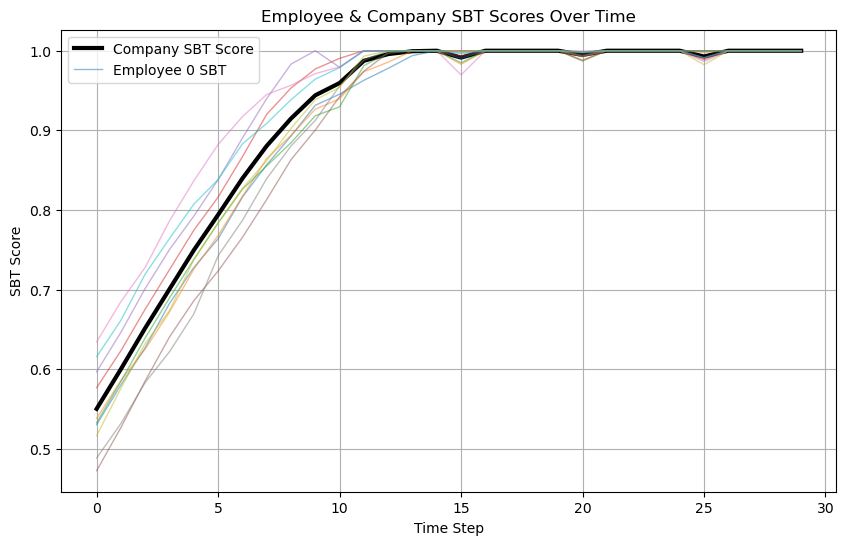

In [1]:
#########################
# Extended SBT Simulation
#########################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact_manual, FloatSlider, IntSlider, Dropdown, Checkbox

# -----------------------------
# Simulation Classes
# -----------------------------
class EmployeeSBT:
    """
    Represents an employee's Soulbound Token (SBT) for their human capital.
    Each SBT tracks multiple skill domains and an overall 'reputation score.'
    """
    def __init__(self, employee_id, num_skills, initial_skill_min=0.3, initial_skill_max=0.7):
        self.employee_id = employee_id
        # Initialize random skill levels (between initial_skill_min and initial_skill_max for demonstration)
        self.skills = np.random.uniform(initial_skill_min, initial_skill_max, size=num_skills)
        self.overall_score = 0.0

    def update_skills(self, skill_improvement_rate):
        """
        Mimics skill improvement each timestep.
        The improvement rate is a random factor around the baseline.
        """
        # Add random improvement to each skill domain
        improvements = np.random.normal(skill_improvement_rate, 0.01, size=len(self.skills))
        self.skills += improvements
        # Ensure skills remain within [0, 1] boundary
        self.skills = np.clip(self.skills, 0, 1)

    def perform_360_evaluation(self, evaluation_noise=0.02):
        """
        Simulate a 360-degree evaluation that adds variability or 'noise'
        to the measured skill values (managers, peers, self, customers).
        """
        noise = np.random.normal(0, evaluation_noise, size=len(self.skills))
        self.skills = np.clip(self.skills + noise, 0, 1)

    def compute_overall_score(self, weighting_factors):
        """
        Compute overall SBT score as a weighted sum of skill domains.
        """
        self.overall_score = np.dot(self.skills, weighting_factors)


class CompanySBT:
    """
    Represents the company's aggregated SBT.
    """
    def __init__(self):
        self.company_score_history = []

    def aggregate_company_score(self, employees, method='mean'):
        """
        Aggregates individual SBT scores into a single company-level measure.
        Different methods can significantly change the result.
        """
        scores = [emp.overall_score for emp in employees]
        
        if method == 'mean':
            return np.mean(scores)
        elif method == 'median':
            return np.median(scores)
        elif method == 'max':
            return np.max(scores)
        elif method == 'min':
            return np.min(scores)
        else:
            # Fallback to mean if unknown method
            return np.mean(scores)


# -----------------------------
# Simulation Function
# -----------------------------
def run_simulation(num_employees=10,
                   num_skills=3,
                   skill_improvement_rate=0.05,
                   evaluation_frequency=5,
                   weighting_factors=None,
                   timesteps=50,
                   aggregation_method='mean',
                   dao_governance_change_timestep=None,
                   new_weighting_factors=None,
                   show_plots=True):
    """
    Run a simulation of employees' SBT evolution over a given number of timesteps,
    with optional mid-simulation DAO governance change in weighting factors.

    Parameters:
        num_employees (int): Number of employees to simulate.
        num_skills (int): Number of skill domains per employee.
        skill_improvement_rate (float): Baseline skill improvement rate each timestep.
        evaluation_frequency (int): Perform a 360 evaluation every N timesteps.
        weighting_factors (array): Initial weighting factors for skill domains.
        timesteps (int): Number of timesteps in the simulation.
        aggregation_method (str): Method for aggregating individual scores ('mean', 'median', 'max', etc.).
        dao_governance_change_timestep (int): If set, triggers a change in weighting_factors at this timestep.
        new_weighting_factors (array): Weighting factors to switch to when DAO triggers.
        show_plots (bool): If True, plot the results at the end.

    Returns:
        df_history (pd.DataFrame): DataFrame with employee-level and company-level scores over time.
    """
    if weighting_factors is None:
        # Default weighting for 3 skills: 40%, 30%, 30%
        weighting_factors = np.array([0.4, 0.3, 0.3])
        
    # Ensure weighting factors shape matches num_skills
    if len(weighting_factors) != num_skills:
        raise ValueError("weighting_factors length must match num_skills.")
    
    # Instantiate employees
    employees = [
        EmployeeSBT(employee_id=i, num_skills=num_skills) 
        for i in range(num_employees)
    ]
    
    # Instantiate company aggregator
    company_sbt = CompanySBT()
    
    # Data storage
    history = {
        'timestep': [],
        'company_score': []
    }
    # We also track each employee's overall score at each timestep
    for i in range(num_employees):
        history[f'employee_{i}_score'] = []

    # Simulation loop
    for t in range(timesteps):
        # Perform DAO governance change at a specific timestep if requested
        if dao_governance_change_timestep is not None and new_weighting_factors is not None:
            if t == dao_governance_change_timestep:
                weighting_factors = new_weighting_factors
                # Optional: print a message or log it
                # print(f"DAO governance triggered at timestep {t}; new weighting: {weighting_factors}")

        # Determine if we do a formal 360 evaluation at this timestep
        do_evaluation = (t % evaluation_frequency == 0) and (t != 0)

        for emp in employees:
            # Each timestep, skills naturally improve
            emp.update_skills(skill_improvement_rate)
            
            # Add 360 evaluation noise on specific timesteps
            if do_evaluation:
                emp.perform_360_evaluation(evaluation_noise=0.02)

            # Recompute overall SBT with current weighting factors
            emp.compute_overall_score(weighting_factors)

        # Aggregate company's SBT
        company_score = company_sbt.aggregate_company_score(employees, method=aggregation_method)
        company_sbt.company_score_history.append(company_score)
        
        # Log to history
        history['timestep'].append(t)
        history['company_score'].append(company_score)
        for i, emp in enumerate(employees):
            history[f'employee_{i}_score'].append(emp.overall_score)
    
    # Convert to DataFrame for analysis
    df_history = pd.DataFrame(history)
    
    # Plot results
    if show_plots:
        plt.figure(figsize=(10, 6))
        # Plot Company SBT
        plt.plot(df_history['timestep'], df_history['company_score'],
                 label='Company SBT Score', linewidth=3, color='black')
        
        # Plot each employee's line
        for i in range(num_employees):
            plt.plot(df_history['timestep'], df_history[f'employee_{i}_score'],
                     alpha=0.5, linewidth=1, label=f'Employee {i} SBT' if i == 0 else "")

        plt.title("Employee & Company SBT Scores Over Time")
        plt.xlabel("Time Step")
        plt.ylabel("SBT Score")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    return df_history


# ---------------------------------------
# Interactive Sliders & Button (ipywidgets)
# ---------------------------------------
# Note: This portion requires a Jupyter Notebook environment.

def interactive_simulation():
    """
    Provide an interactive environment in a Jupyter Notebook
    to vary simulation parameters via sliders and run on demand.
    """
    # Sliders & controls
    w_num_employees = IntSlider(value=10, min=1, max=50, step=1, description='Num Employees')
    w_skill_improvement_rate = FloatSlider(value=0.05, min=0.0, max=0.2, step=0.01, 
                                           description='Skill Improve Rate')
    w_evaluation_frequency = IntSlider(value=5, min=1, max=20, step=1, 
                                       description='Eval Frequency')
    w_timesteps = IntSlider(value=30, min=10, max=100, step=5, description='Timesteps')
    w_aggregation_method = Dropdown(options=['mean','median','max','min'],
                                    value='mean',
                                    description='Aggregation')
    w_dao_change = Checkbox(value=False, description='DAO Change Mid-Sim?')
    w_dao_change_timestep = IntSlider(value=15, min=1, max=99, step=1, 
                                      description='DAO Change Timestep')
    
    @interact_manual(
        num_employees=w_num_employees,
        skill_improvement_rate=w_skill_improvement_rate,
        evaluation_frequency=w_evaluation_frequency,
        timesteps=w_timesteps,
        aggregation_method=w_aggregation_method,
        dao_governance_change=w_dao_change,
        dao_governance_change_timestep=w_dao_change_timestep
    )
    def run_interactive(num_employees, skill_improvement_rate, evaluation_frequency,
                        timesteps, aggregation_method, dao_governance_change,
                        dao_governance_change_timestep):
        """
        Called when the user clicks the 'Run Interact' button. 
        We can define default weighting factors and possible new weighting factors for demonstration.
        """
        # Default weighting factors for 3-skill model
        weighting_factors = np.array([0.4, 0.3, 0.3])
        
        # Optional new weighting (example: shift from [0.4, 0.3, 0.3] to [0.2, 0.5, 0.3])
        # to emphasize the second skill more after DAO voting
        new_weighting_factors = np.array([0.2, 0.5, 0.3])
        
        if dao_governance_change:
            run_simulation(
                num_employees=num_employees,
                num_skills=3,
                skill_improvement_rate=skill_improvement_rate,
                evaluation_frequency=evaluation_frequency,
                weighting_factors=weighting_factors,
                timesteps=timesteps,
                aggregation_method=aggregation_method,
                dao_governance_change_timestep=dao_governance_change_timestep,
                new_weighting_factors=new_weighting_factors,
                show_plots=True
            )
        else:
            run_simulation(
                num_employees=num_employees,
                num_skills=3,
                skill_improvement_rate=skill_improvement_rate,
                evaluation_frequency=evaluation_frequency,
                weighting_factors=weighting_factors,
                timesteps=timesteps,
                aggregation_method=aggregation_method,
                dao_governance_change_timestep=None,  # no governance change
                new_weighting_factors=None,
                show_plots=True
            )


# -----------------------------
# How to Use (in a Notebook)
# -----------------------------
if __name__ == "__main__":
    # 1) Run a single example in plain Python (non-interactive)
    print("Running a single example simulation (non-interactive mode)...")
    df_example = run_simulation(
        num_employees=10,
        num_skills=3,
        skill_improvement_rate=0.05,
        evaluation_frequency=5,
        weighting_factors=np.array([0.4, 0.3, 0.3]),
        timesteps=30,
        aggregation_method='mean',
        dao_governance_change_timestep=15,  # Example: DAO changes at t=15
        new_weighting_factors=np.array([0.2, 0.5, 0.3]),  # Switch emphasis
        show_plots=True
    )
    
    # 2) If you're in a Jupyter Notebook, uncomment and run:
    # interactive_simulation()


In [3]:
interactive_simulation() 
# Baseline
# Num Employees: 50
# Skill Improvement Rate: ~0.01
# Evaluation Frequency: 5
# Timesteps: 50
# Aggregation: mean
# DAO Change Mid-Sim: unchecked


interactive(children=(IntSlider(value=10, description='Num Employees', max=50, min=1), FloatSlider(value=0.05,…

In [4]:
interactive_simulation() 
# Eval freq
# Num Employees: 50
# Skill Improvement Rate: ~0.01
# Evaluation Frequency: 1 (every)
# Timesteps: 50
# Aggregation: mean
# DAO Change Mid-Sim: unchecked


interactive(children=(IntSlider(value=10, description='Num Employees', max=50, min=1), FloatSlider(value=0.05,…

In [5]:
interactive_simulation() 
# high skill improvement rate
# Num Employees: 50
# Skill Improvement Rate: ~0.15
# Evaluation Frequency: 5 (every)
# Timesteps: 50
# Aggregation: mean
# DAO Change Mid-Sim: unchecked


interactive(children=(IntSlider(value=10, description='Num Employees', max=50, min=1), FloatSlider(value=0.05,…

In [6]:
interactive_simulation() 
# Dao governance like change 
# Num Employees: 50
# Skill Improvement Rate: ~0.05
# Evaluation Frequency: 5
# Timesteps: 50
# Aggregation: mean
# DAO Change Mid-Sim: checked


interactive(children=(IntSlider(value=10, description='Num Employees', max=50, min=1), FloatSlider(value=0.05,…